In [217]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import re

In [218]:
df = pd.read_csv('../Maj2NLP/data/questions_preprocessed.csv', encoding='ISO-8859-1')

In [219]:
df['all_text'] = df['Title'] + ' ' + df['Body']

In [220]:
max_len=377

In [221]:
def bad_question(score):
    if score < 0:
        return 1
    else:
        return 0

df['bad_question'] = df['Score'].apply(lambda x: bad_question(x))

In [222]:
df_questions = df[['all_text', 'bad_question']]
train, test = train_test_split(df_questions, test_size=0.2, random_state=42)

In [223]:
train_bad = train.loc[train['bad_question'] == 1]
train_good = train.loc[train['bad_question'] == 0]

## Try using RNN
#### https://www.tensorflow.org/alpha/tutorials/sequences/text_classification_rnn
#### https://www.kaggle.com/kredy10/simple-lstm-for-text-classification

In [224]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [225]:
X_train = train['all_text']
y_train = train['bad_question']
X_test = test['all_text']
y_test = test['bad_question']

In [226]:
tok = Tokenizer()
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences)

In [227]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(2000,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.9)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [228]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 377)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 377, 50)           100000    
                                                                 
 lstm_11 (LSTM)              (None, 8)                 1888      
                                                                 
 FC1 (Dense)                 (None, 8)                 72        
                                                                 
 activation_22 (Activation)  (None, 8)                 0         
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 out_layer (Dense)           (None, 1)                 9  

In [229]:
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs=20,
          validation_split=0.2)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6924 - accuracy: 0.8947 - val_loss: 0.6863 - val_accuracy: 1.0000
Epoch 2/10
1/1 [==============================] - 0s 139ms/step - loss: 0.6871 - accuracy: 0.9737 - val_loss: 0.6804 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 142ms/step - loss: 0.6766 - accuracy: 1.0000 - val_loss: 0.6735 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 136ms/step - loss: 0.6753 - accuracy: 1.0000 - val_loss: 0.6679 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 138ms/step - loss: 0.6653 - accuracy: 1.0000 - val_loss: 0.6605 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 139ms/step - loss: 0.6557 - accuracy: 1.0000 - val_loss: 0.6524 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 136ms/step - loss: 0.6634 - accuracy: 1.0000 - val_loss: 0.6466 - val_accuracy: 1.0000
Epoch 8/10
1/1 [=======

In [230]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [231]:
y_hat = model.predict(test_sequences_matrix, verbose = 1)

1/1 [==============================] - 0s 346ms/step


In [232]:
y_hat[y_hat > 0.5] = 1
y_hat[y_hat <= 0.5] = 0
precision_recall_fscore_support(y_test, y_hat, average='macro')

(1.0, 1.0, 1.0, None)

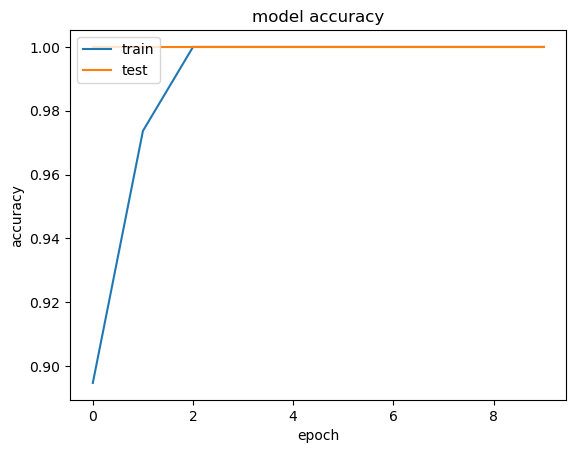

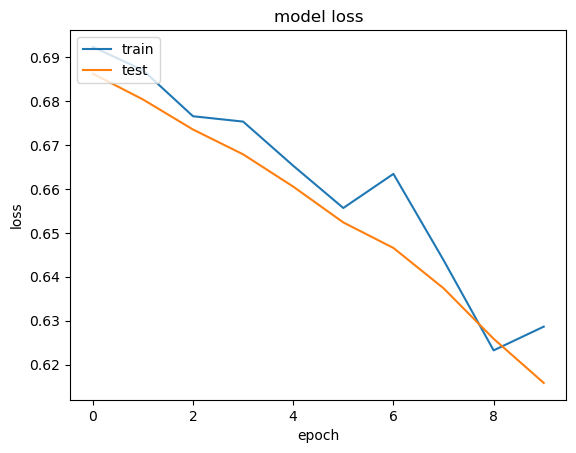

In [233]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [236]:
y_hat[y_hat > 0.5] = 1
y_hat[y_hat <= 0.5] = 0
a_afficher=precision_recall_fscore_support(y_test, y_hat, average='macro')
print(f"Précision sur le jeu de test : {a_afficher[0]*100}")
print(f"Recall sur le jeu de test : {a_afficher[0]*100}")

Précision sur le jeu de test : 100.0
Recall sur le jeu de test : 100.0
